In [1]:
import numpy as np
from astropy.io import fits
import pylab as pl
import healpy as hp
from glob import glob

In [2]:
import matplotlib.colors as colors

# Check one file

In [145]:
root = "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/lya_mocks/mock_analysis/qq_desi_y5/skewers_desi_footprint.5/analysis-0/jura-0/"
root += "true_cont/deltas_lya/Delta/"

In [146]:
example_file = root + "delta-1375.fits.gz"
hdu=fits.open(example_file)

In [13]:
# print table information:
hdu.info

<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7ff6978a9ca0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7ff69710bd90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7ff6971f3520>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7ff69710b7c0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7ff697118220>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7ff6971183a0>]>

In [14]:
len(hdu)

6

In [7]:
for i in range(1, len(hdu)):
    print(i)
    print(hdu[i].header)
    print("\\")

1
XTENSION= 'IMAGE   '           / IMAGE extension                                BITPIX  =                  -64 / number of bits per data pixel                  NAXIS   =                    1 / number of data axes                            NAXIS1  =                 2716 / length of data axis 1                          PCOUNT  =                    0 / required keyword; must = 0                     GCOUNT  =                    1 / required keyword; must = 1                     EXTNAME = 'LAMBDA  '                                                            BUNIT   = 'Angstrom'           / wavelength units                               HIERARCH WAVE_SOLUTION = 'lin     ' / chosen wavelength solution                HIERARCH DELTA_LAMBDA =    0.8 / pixel step                                     COMMENT Wavelength grid                                                         CHECKSUM= 'VD9SYD6QVD6QVD6Q'   / HDU checksum updated 2025-02-18T22:08:15       DATASUM = '1634060384'         / data 

In [147]:
wave = hdu[1].data
ra = hdu[2].data['RA']
dec = hdu[2].data['DEC']
zqso = hdu[2].data['Z']
qid= hdu[2].data['LOS_ID']
delta = hdu[3].data
weights = hdu[4].data
cont = hdu[5].data

In [148]:
wave

array([3600. , 3600.8, 3601.6, ..., 5498.4, 5499.2, 5500. ])

In [18]:
# save the wavelength grid, as for raw this is partial
np.savetxt("../codes/wave.txt", wave)

In [19]:
np.loadtxt("../codes/wave.txt")

array([3600. , 3600.8, 3601.6, ..., 5498.4, 5499.2, 5500. ])

In [5]:
obj_ind = np.where(qid==500064150)[0][0]
print(obj_ind)

431


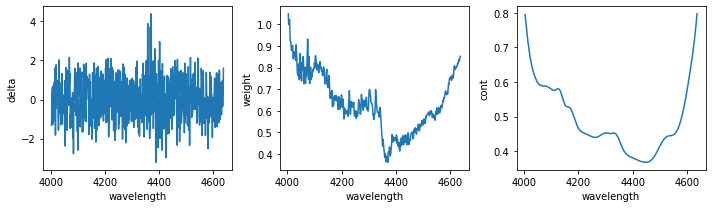

In [61]:
fig,axarr=pl.subplots(1,3,figsize=[10,3])
pl.sca(axarr[0])
pl.plot(wave, delta[obj_ind, :])
pl.xlabel("wavelength")
pl.ylabel("delta")

pl.sca(axarr[1])
pl.plot(wave, weights[obj_ind, :])
pl.xlabel("wavelength")
pl.ylabel("weight")

pl.sca(axarr[2])
pl.plot(wave, cont[obj_ind, :])
pl.xlabel("wavelength")
pl.ylabel("cont")

pl.tight_layout()

In [5]:
# inspect results from one run:
fin = fits.open("/pscratch/sd/q/qhang/desi-lya/delta_F-noise/delta-noisy-desi-footprint-chunk-0.fits")

In [6]:
fin[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   56 / length of dimension 1                          
NAXIS2  =               318261 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    7 / number of table fields                         
TTYPE1  = 'RA      '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'DEC     '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'Z       '        

In [7]:
ra = fin[1].data['RA']
dec = fin[1].data['DEC']

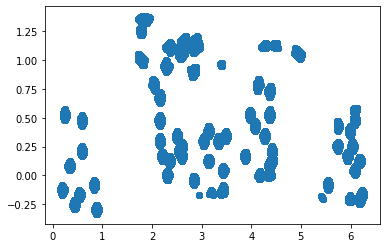

In [8]:
pl.scatter(ra, dec)

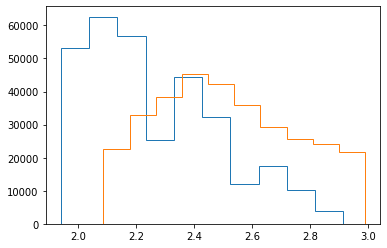

In [9]:
cc=pl.hist(fin[1].data['Z'],histtype='step')
cc=pl.hist(fin[1].data['ZQSO'],histtype='step')

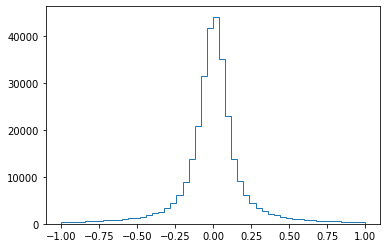

In [10]:
cc=pl.hist(fin[1].data['DELTA_F'],range=[-1,1],bins=50, histtype='step')

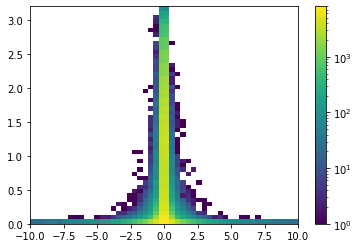

In [12]:
cc=pl.hist2d(fin[1].data['DELTA_F'], fin[1].data['TOTWEIGHTS']/fin[1].data['NPIX'],
            bins=[50,50], norm=colors.LogNorm(),range=[[-10,10],[0,3.2]])
pl.colorbar()

In [16]:
weights = fin[1].data['TOTWEIGHTS']/fin[1].data['NPIX']
print(sum(weights == 0))
print(fin[1].data['DELTA_F'][weights == 0])

36
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# we can mask some pixels with very low weights (compare with no masking etc.)

# Check combine runs

In [17]:
# functions
def save_catalog_to_fits(fname, data_matrix):
    c=[]
    dtype_to_fits_type = {'int64': 'K',
                          'float64': 'D',
                          'float32': 'E',
                          '<U6': '20A',
                          'bool': 'bool',
                          '>f8': 'D',
                          '>f4': 'E',
                         }
    
    for ii, keys in enumerate(data_matrix.keys()):
        col=fits.Column(name=keys, array=data_matrix[keys],
                        format=dtype_to_fits_type[str(data_matrix[keys].dtype)])
        c.append(col)
    t = fits.BinTableHDU.from_columns(c)
    t.writeto(fname)


In [19]:
keys = ['RA', 'DEC', 'Z', 'ZQSO', 'DELTA_F', 'NPIX', 'TOTWEIGHTS']
data_holder = {}
for key in keys:
    data_holder[key] = np.array([])

nchunks = 16
root = "/pscratch/sd/q/qhang/desi-lya/delta_F-noise/"
for n in range(nchunks):
    fname = root +  f"delta-noisy-desi-footprint-chunk-{n}.fits"
    fin = fits.open(fname)
    for key in keys:
        data_holder[key] = np.append(data_holder[key], fin[1].data[key])

print("Number of objects in chunk: ", len(data_holder["DELTA_F"]))
# save
savename = root + "delta-noisy-desi-footprint.fits"
save_catalog_to_fits(savename, data_holder)
print(f"saved: {savename}")

Number of objects in chunk:  5164256
saved: /pscratch/sd/q/qhang/desi-lya/delta_F-noise/delta-noisy-desi-footprint.fits


# raw 

3072
529


array([1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087,
       1088, 1089, 1090, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1100,
       1101, 1102, 1103, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147,
       1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158,
       1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1204, 1205,
       1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216,
       1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227,
       1228, 1229, 1230, 1231, 1268, 1269, 1270, 1271, 1272, 1273, 1274,
       1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285,
       1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1333, 1334,
       1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345,
       1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356,
       1357, 1358, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384,
       1397, 1398, 1399, 1400, 1401, 1402, 1403, 14

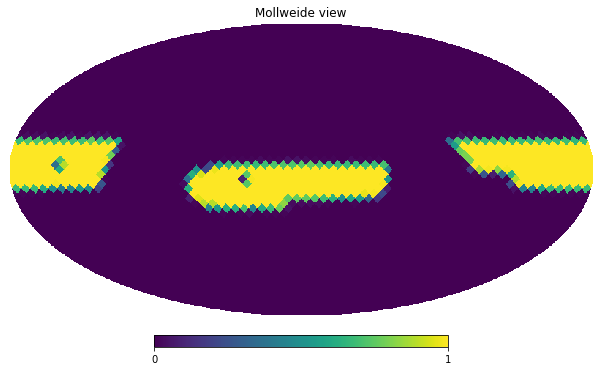

In [18]:
# figure out pixels to use:
mask = hp.read_map("/pscratch/sd/q/qhang/desi-lya/desixlsst-mask-nside-128.fits")
nside=hp.get_nside(mask)
mask_degrade = hp.ud_grade(mask, 16)
hp.mollview(mask_degrade)
print(12*16**2)
print(sum(mask_degrade.astype(bool)))
pixels_in_mask = np.arange(12*16**2)[mask_degrade.astype(bool)]
#pixels_in_mask

In [25]:
fname_list[1][161:-8]

'1146'

In [28]:
fname_pix = []
for i in range(len(fname_list)):
    fname_pix.append(int(fname_list[i][161:-8]))
fname_pix = np.array(fname_pix)

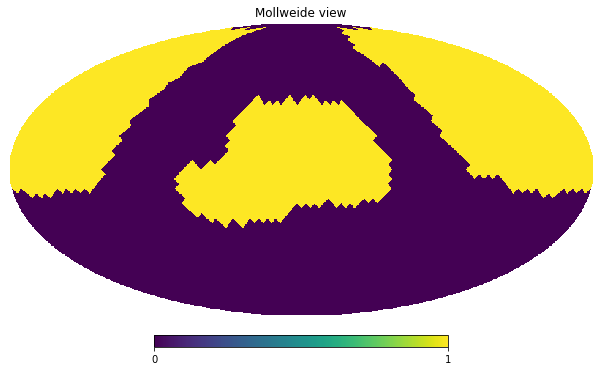

In [31]:
fname_mask = np.zeros(12*16**2)
fname_mask[fname_pix]=1
hp.mollview(fname_mask)

In [59]:
fin = fits.open("/pscratch/sd/q/qhang/desi-lya/results/run-0/catalogue-20bin/delta-raw.fits")
#fin = fits.open("/pscratch/sd/q/qhang/desi-lya/results/run-0/catalogue-20bin/delta-raw-chunk-37.fits")
fin[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   32 / length of dimension 1                          
NAXIS2  =              2450460 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    8 / number of table fields                         
TTYPE1  = 'RA      '                                                            
TFORM1  = 'E       '                                                            
TTYPE2  = 'DEC     '                                                            
TFORM2  = 'E       '                                                            
TTYPE3  = 'Z       '        

In [60]:
delta_F = fin[1].data["DELTA_F"]
delta_F_w = fin[1].data["DELTA_F_WEIGHTED"]

In [61]:
print(fin[1].data["Z"])

[2.175 2.225 2.275 ... 2.575 2.625 2.675]


[-0.13146271  0.11366183  0.02653359 -0.00085573 -0.15748441]
[-0.13321461  0.11282156  0.02595794 -0.00031416 -0.15929106]


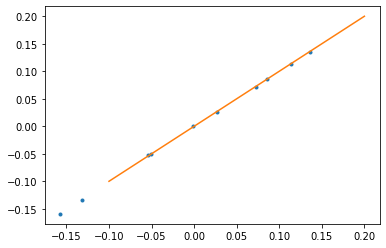

In [65]:
pl.plot(delta_F[:10], delta_F_w[:10],'.')
pl.plot([-0.1,0.2],[-0.1,0.2])
print(delta_F[:5])
print(delta_F_w[:5])

In [64]:
1/(1+smoothed_delta_f)-1

array([ 5.74952094e-04,  1.71383114e-04, -4.64889435e-05, -1.95880034e-04,
        1.92441680e-04, -2.29238626e-04,  3.44910256e-04, -1.03206439e-04,
        1.26959215e-04,  9.87518432e-04,  5.18058191e-04,  4.73846861e-05,
        1.14057485e-03,  4.10105079e-04,  1.65385902e-04, -1.39044434e-03,
        5.83373749e-04, -5.41949377e-04, -1.29220409e-02,  0.00000000e+00])

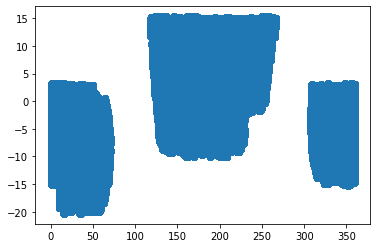

In [4]:
ra = fin[1].data['RA']
dec = fin[1].data['DEC']
pl.scatter(ra, dec)

In [5]:
fin2 = fits.open("/pscratch/sd/q/qhang/desi-lya/delta_F-noise/delta-noisy-overlap-footprint.fits")
fin2[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   48 / length of dimension 1                          
NAXIS2  =              2185229 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    6 / number of table fields                         
TTYPE1  = 'RA      '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'DEC     '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'Z       '        

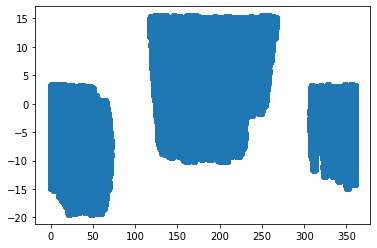

In [7]:
ra = fin2[1].data['RA']
dec = fin2[1].data['DEC']
pl.scatter(ra*180/np.pi, dec*180/np.pi)

In [8]:
fin3 = fits.open("/pscratch/sd/q/qhang/desi-lya/delta_F-noise/delta-noisy-desi-footprint.fits")
#fin3[1].header

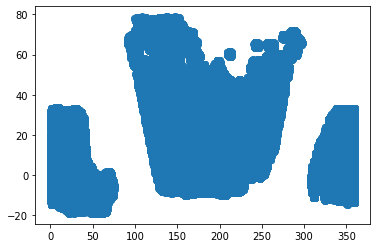

In [9]:
ra = fin3[1].data['RA'][::5]
dec = fin3[1].data['DEC'][::5]
pl.scatter(ra*180/np.pi, dec*180/np.pi)

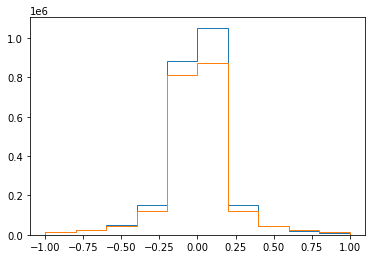

In [20]:
cc=pl.hist(fin[1].data['DELTA_F'],histtype='step',range=[-1,1])
cc=pl.hist(fin2[1].data['DELTA_F'],bins=cc[1],histtype='step')

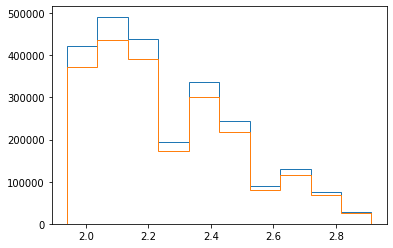

In [17]:
cc=pl.hist(fin[1].data['Z'],histtype='step')
cc=pl.hist(fin2[1].data['Z'],bins=cc[1],histtype='step')

Check corrupted file:

In [6]:
# read in redshift bin somewhere, or save it with the results;
sim_num=2
sim_mode_tag='true_cont'
nchunks = 16

simroot = "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/lya_mocks/mock_analysis/qq_desi_y5/skewers_desi_footprint.5/"
simroot += f"analysis-{sim_num}/jura-0/{sim_mode_tag}/deltas_lya/Delta/"

In [14]:
fname_list = glob(simroot + "*.fits.gz", recursive = True)
print("Total files to go through: ", len(fname_list))
print(f"Splitting into {nchunks} chunks...")
# here, split the file list to chunks and send to different nodes:
Nfiles = int(len(fname_list)/nchunks)+1
fname_chunks = []
for kk in range(nchunks):
    if kk < nchunks - 1 :
        fname_chunks.append(fname_list[(kk*Nfiles):((kk+1)*Nfiles)])
    elif kk == nchunks - 1 :
        fname_chunks.append(fname_list[(kk*Nfiles):])
print(f"Chunk {12} contains {len(fname_chunks[12])} files.")
#print(fname_chunks[12])

# check which file is corrupt:
task=12
error_list = np.array([8])
for mm in range(len(fname_chunks[task])):
    if mm not in error_list:
        hdu = fits.open(fname_chunks[task][mm])
        hdu.close()

Total files to go through:  1244
Splitting into 16 chunks...
Chunk 12 contains 78 files.


In [16]:
8, fname_chunks[task][8]

(8,
 '/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/lya_mocks/mock_analysis/qq_desi_y5/skewers_desi_footprint.5/analysis-2/jura-0/true_cont/deltas_lya/Delta/delta-2084.fits.gz')

In [60]:
# check wavelength grid:

sim_mode_tag = 'raw'
sim_num = 0
# read in redshift bin somewhere, or save it with the results;
simroot = "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/lya_mocks/mock_analysis/qq_desi_y5/skewers_desi_footprint.5/"
simroot += f"analysis-{sim_num}/jura-0/{sim_mode_tag}/deltas_lya/Delta/"

maskfname= "/pscratch/sd/q/qhang/desi-lya/desixlsst-mask-nside-128.fits"

mask = hp.read_map(maskfname)
nside=hp.get_nside(mask)
npix = round(12*nside**2,0)
usepix = np.arange(npix)[mask==1]

# Determine list of fnames to use within the mask:
mask_degrade = hp.ud_grade(mask, 16)
#hp.mollview(mask_degrade)
pixels_in_mask = np.arange(12*16**2)[mask_degrade.astype(bool)]

fname_list = glob(simroot + "*.fits.gz", recursive = True)
fname_pix = []
for i in range(len(fname_list)):
    fname_pix.append(int(fname_list[i][(len(simroot) + 6):-8]))
fname_pix = np.array(fname_pix)
fname_ind = np.in1d(fname_pix, pixels_in_mask)
fname_list = np.array(fname_list)[fname_ind]
print("Total files to go through: ", len(fname_list))

fname = fname_list[1]
delta_F = fits.open(fname)

Total files to go through:  515


In [13]:
ind = (10**delta_F[1].data['LOGLAM']>=4144.8)&(10**delta_F[1].data['LOGLAM']<=4148)
print(10**delta_F[1].data['LOGLAM'][ind])
print(10**delta_F[2].data['LOGLAM'][:5])

[4144.8 4145.6 4146.4 4147.2 4148. ]
[4144.8 4145.6 4146.4 4147.2 4148. ]


In [55]:
wave = np.loadtxt("../codes/wave.txt")

In [27]:
ind = (wave>=10**delta_F[2].data['LOGLAM'][0])&(wave<=10**delta_F[2].data['LOGLAM'][5])
print(wave[ind])

[4144.8 4145.6 4146.4 4147.2 4148. ]


In [28]:
(wave[ind][-1])

4148.000000000123

In [26]:
(wave == 10**delta_F[2].data['LOGLAM'][4]).any()

False

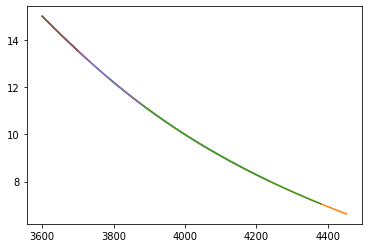

In [62]:
for jj in range(2):
    fname = fname_list[jj]
    delta_F = fits.open(fname)
    for ii in range(3,6):
        wave_i = 10**delta_F[ii+1].data['LOGLAM']
        pl.plot(wave_i, delta_F[ii+1].data['WEIGHT'])

In [110]:
tot_npix=0
tot_delta=0
tot_weights=0
tot_w_delta=0
for jj in range(20,22):
    fname = fname_list[jj]
    delta_F = fits.open(fname)
    for ii in range(5):
        wave_i = 10**delta_F[ii+1].data['LOGLAM']
        wave_use = np.array([4000,4000.8,4001.6])
        ind = (wave_i > (wave_use[0]-0.4))&(wave_i < (wave_use[-1]+0.4))
        print(wave_i[ind])
        if len(wave_i[ind])>0:
            tot_npix+=np.ones(len(wave_i[ind]))
            tot_delta+=delta_F[ii+1].data['DELTA'][ind]
            tot_weights+=delta_F[ii+1].data['WEIGHT'][ind]
            tot_w_delta+=delta_F[ii+1].data['DELTA'][ind]*delta_F[ii+1].data['WEIGHT'][ind]

[4000.  4000.8 4001.6]
[]
[]
[4000.  4000.8 4001.6]
[4000.  4000.8 4001.6]
[4000.  4000.8 4001.6]
[4000.  4000.8 4001.6]
[]
[]
[]


In [111]:
tot_npix, tot_delta, tot_weights,tot_w_delta

(array([5., 5., 5.]),
 array([ 0.90275122,  0.34895537, -0.32165355]),
 array([49.98014845, 49.94146228, 49.90281691]),
 array([ 9.02392801,  3.48546826, -3.21028364]))

In [112]:
tot_delta/tot_npix, tot_w_delta/tot_weights

(array([ 0.18055024,  0.06979107, -0.06433071]),
 array([ 0.18055024,  0.06979107, -0.06433071]))

In [64]:
hduh = delta_F[jj+1].header
ra = hduh['RA']*180/np.pi
dec = hduh['DEC']*180/np.pi
zqso = hduh['Z']

usepix = np.arange(100)

# select objects that lie inside the mask
pix = hp.ang2pix(nside, np.radians(90 - dec), np.radians(ra))
sel1 = np.in1d(pix,usepix)
print(sel1)

[False]


In [65]:
(np.ones(5)).astype(bool)*sel1

array([False, False, False, False, False])

### check n(z)

In [3]:
nz_F_raw = {}
nz_F_raw_avg = 0
for ii in range(10):
    nz_F_raw[ii] = np.loadtxt(f"/pscratch/sd/q/qhang/desi-lya/results/run-{ii}/catalogue-20bin/nz-tot-nobj-delta-raw.txt")
    nz_F_raw_avg += nz_F_raw[ii][:,1:]/10

In [4]:
emit = emit = 1215.67
wave = nz_F_raw[0][:,0]
objred = (wave-emit)/emit

In [5]:
redshift_binedges = np.linspace(2,3,20+1)
redshift_bincen = (redshift_binedges[1:] + redshift_binedges[:-1])/2.

/tmp/ipykernel_1862772/4087921275.py:6: RuntimeWarning: invalid value encountered in divide
  pl.plot(objred, nz_F_raw_avg[:,ii]/sum(nz_F_raw_avg[:,ii])/dz, color=colors[ii],label=label)


Text(0.5, 1.0, 'Raw delta z, W = npix, 10 mock avg')

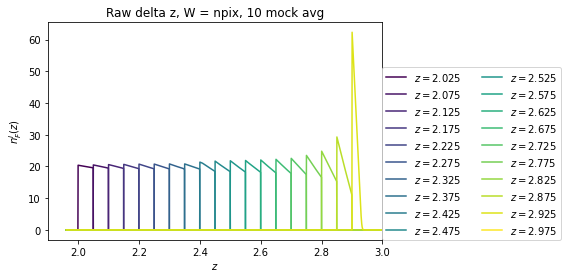

In [6]:
dz = objred[1]-objred[0]
colors = pl.cm.viridis(np.linspace(0,1,20))

for ii in range(20):
    label=f"$z={redshift_bincen[ii]}$"
    pl.plot(objred, nz_F_raw_avg[:,ii]/sum(nz_F_raw_avg[:,ii])/dz, color=colors[ii],label=label)
pl.legend(loc=[1,0],ncol=2)
pl.xlim([1.9,3.0])
pl.xlabel("$z$")
pl.ylabel("$n_F^I(z)$")
pl.title("Raw delta z, W = npix, 10 mock avg")

In [11]:
# save a nz somewhere:
for ii in range(19):
    if ii == 0:
        out = np.c_[objred, nz_F_raw_avg[:,ii]/sum(nz_F_raw_avg[:,ii])/dz]
    else:
        out = np.c_[out,nz_F_raw_avg[:,ii]/sum(nz_F_raw_avg[:,ii])/dz]
out = np.c_[out, np.zeros(len(objred))]
fname = "/pscratch/sd/q/qhang/desi-lya/results/nz_F_raw-20bin-mock-avg.txt"
np.savetxt(fname, out)

### Normalization

In [37]:
fin = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/results-newbias/run-0/catalogue/norm-delta-raw.txt")
fin = np.nan_to_num(fin)

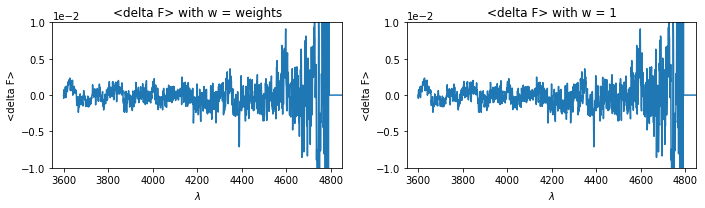

In [39]:
wave = np.loadtxt("../codes/wave.txt")
emit = 1215.67
objred = (wave-emit)/emit

fig,axarr=pl.subplots(1,2,figsize=[10,3])
pl.sca(axarr[0])
pl.plot(wave, fin[:,0])
pl.ylim([-1e-2,1e-2])
pl.title("<delta F> with w = weights")
pl.xlabel("$\\lambda$")
pl.ylabel("<delta F>")
pl.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
pl.xlim([3550, 4850])

pl.sca(axarr[1])
pl.plot(wave, fin[:,1])
pl.ylim([-1e-2,1e-2])
pl.title("<delta F> with w = 1")
pl.xlabel("$\\lambda$")
pl.ylabel("<delta F>")
pl.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
pl.xlim([3550, 4850])

pl.tight_layout()

In [40]:
fin[:5,0], fin[:5,1]

(array([ 0.        , -0.00043423,  0.00063538,  0.0007611 ,  0.0004739 ]),
 array([ 0.        , -0.00043423,  0.00063538,  0.0007611 ,  0.0004739 ]))

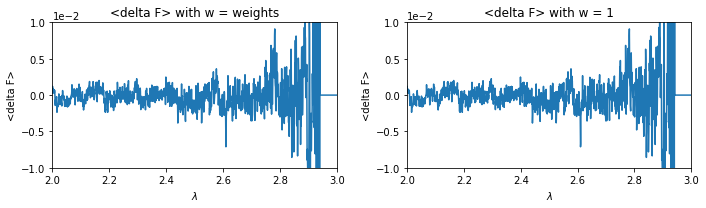

In [41]:
fig,axarr=pl.subplots(1,2,figsize=[10,3])
pl.sca(axarr[0])
pl.plot(objred, fin[:,0])
pl.ylim([-1e-2,1e-2])
pl.title("<delta F> with w = weights")
pl.xlabel("$\\lambda$")
pl.ylabel("<delta F>")
pl.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
pl.xlim([2,3])

pl.sca(axarr[1])
pl.plot(objred, fin[:,1])
pl.ylim([-1e-2,1e-2])
pl.title("<delta F> with w = 1")
pl.xlabel("$\\lambda$")
pl.ylabel("<delta F>")
pl.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
pl.xlim([2,3])

pl.tight_layout()

They are the same for raw analysis, as expected.

In [42]:
zedges = np.linspace(2,3,21)
smoothed_delta_f=np.zeros(20)
for ii in range(20):
    ind = (objred>=zedges[ii])&(objred<zedges[ii+1])
    smoothed_delta_f[ii] = np.mean(fin[ind,0])

(2.0, 3.0)

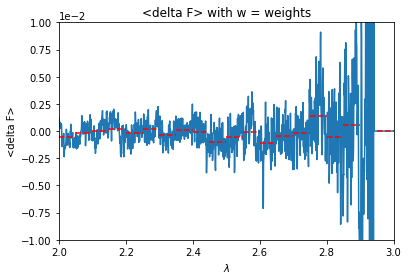

In [43]:
pl.plot(objred, fin[:,0])
for ii in range(20):
    pl.plot([zedges[ii],zedges[ii+1]], 
            [smoothed_delta_f[ii],smoothed_delta_f[ii]], color='r',ls='--')
pl.ylim([-1e-2,1e-2])
pl.title("<delta F> with w = weights")
pl.xlabel("$\\lambda$")
pl.ylabel("<delta F>")
pl.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
pl.xlim([2,3])

In [137]:
zedges = np.linspace(2,3,21)
smoothed_delta_f=np.zeros((20, 10))
for jj in range(10):
    fin = np.loadtxt(f"/pscratch/sd/q/qhang/desi-lya/results-newbias/run-{jj}/catalogue/norm-delta-raw.txt")
    fin = np.nan_to_num(fin)
    
    for ii in range(20):
        ind = (objred>=zedges[ii])&(objred<zedges[ii+1])
        smoothed_delta_f[ii,jj] = np.mean(fin[ind,0])

(2.0, 3.0)

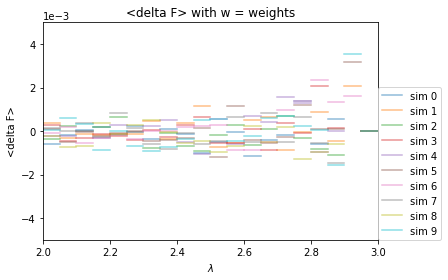

In [144]:
for jj in range(10):
    for ii in range(20):
        if ii == 0:
            label=f"sim {jj}"
        else:
            label=None
        pl.plot([zedges[ii],zedges[ii+1]], 
                [smoothed_delta_f[ii,jj],smoothed_delta_f[ii,jj]], color=f'C{jj}',alpha=0.5,label=label)

pl.legend(loc=[1,0])
pl.ylim([-5e-3,5e-3])
pl.title("<delta F> with w = weights")
pl.xlabel("$\\lambda$")
pl.ylabel("<delta F>")
pl.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
pl.xlim([2,3])

0 0 0
0 1 1
1 0 2
1 1 3


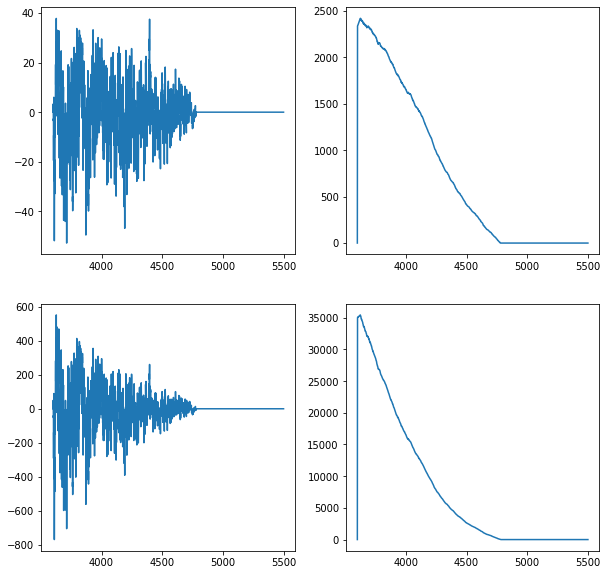

In [124]:
fig,axarr=pl.subplots(2,2,figsize=[10,10])

for ii in range(2):
    for jj in range(2):
        pl.sca(axarr[ii,jj])
        kk = ii*2 + jj
        print(ii,jj,kk)
        pl.plot(wave, fin[:,kk])

In [ ]:
# we could also check this mean for all mocks

# check if this is the same as the ones used in yaw: 
# the ones used in yaw would be sum(kappa * kapp_weights)/sum(kappa_weights) for all 
# kappas in the redshift bin





# true cont

In [226]:
fin = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/results-newbias/run-0/catalogue/norm-delta-true_cont-chunk-10.txt")

0 0 0
0 1 1
1 0 2
1 1 3


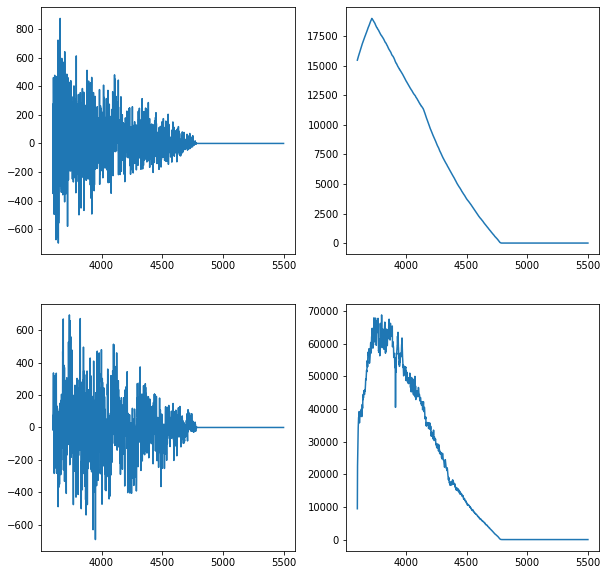

In [227]:
fig,axarr=pl.subplots(2,2,figsize=[10,10])

for ii in range(2):
    for jj in range(2):
        pl.sca(axarr[ii,jj])
        kk = ii*2 + jj
        print(ii,jj,kk)
        pl.plot(wave, fin[:,kk])

In [231]:
fin = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/results-newbias/run-0/catalogue/norm-delta-true_cont.txt")
fin = np.nan_to_num(fin)

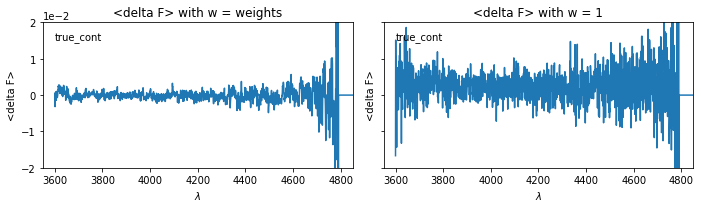

In [237]:
fig,axarr=pl.subplots(1,2,figsize=[10,3],sharey=True)
pl.sca(axarr[0])
pl.plot(wave, fin[:,0])
pl.ylim([-2e-2,2e-2])
pl.title("<delta F> with w = weights")
pl.xlabel("$\\lambda$")
pl.ylabel("<delta F>")
pl.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
pl.xlim([3550, 4850])
pl.text(3600,1.5e-2,"true_cont")

pl.sca(axarr[1])
pl.plot(wave, fin[:,1])
pl.ylim([-2e-2,2e-2])
pl.title("<delta F> with w = 1")
pl.xlabel("$\\lambda$")
pl.ylabel("<delta F>")
pl.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
pl.xlim([3550, 4850])
pl.text(3600,1.5e-2,"true_cont")

pl.tight_layout()

In [162]:
# okay we can double check this computation:

fname = "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/lya_mocks/mock_analysis/qq_desi_y5/skewers_desi_footprint.5/analysis-0/jura-0/true_cont/deltas_lya/Delta/delta-1146.fits.gz"

hdu = fits.open(fname)
wave = hdu[1].data # this is the same for all runs / objects
#ra = hdu[2].data['RA']*180/np.pi
#dec = hdu[2].data['DEC']*180/np.pi
#zqso = hdu[2].data['Z']
#qid= hdu[2].data['LOS_ID']
delta = hdu[3].data
weights = hdu[4].data

In [167]:
delta = np.nan_to_num(delta, 0)
weights = np.nan_to_num(weights, 0)

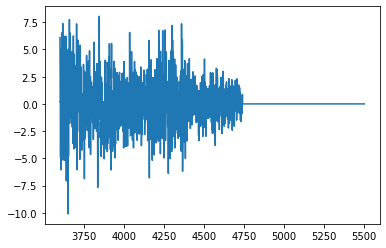

In [184]:
sum_delta = np.sum(delta[:10,:],axis=0)
pl.plot(wave, sum_delta)

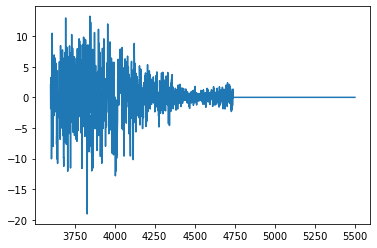

In [186]:
sum_wdelta = np.sum(delta[:10,:]*weights[:10,:],axis=0)
pl.plot(wave, sum_wdelta)

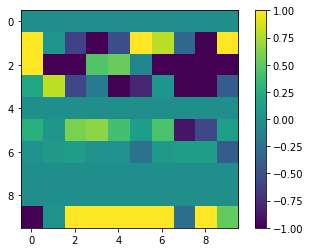

In [204]:
pl.imshow(delta[:10,:10]*weights[:10,:10],vmax=1,vmin=-1)
pl.colorbar()

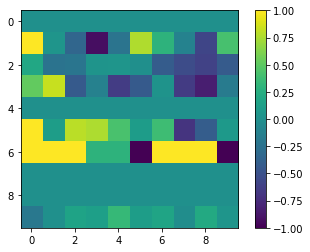

In [203]:
pl.imshow(delta[:10,:10],vmax=1,vmin=-1)
pl.colorbar()

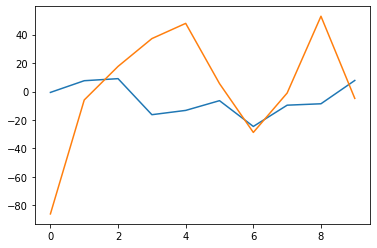

In [215]:
pl.plot(np.sum(delta[100:200,:10]*weights[100:200,:10],axis=0))
#pl.plot(np.sum(delta[:10,:10],axis=0))
pl.plot(np.sum(delta[100:200,:10]*unit_weights[100:200,:10],axis=0))

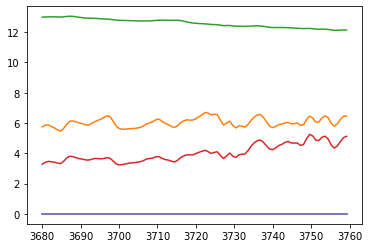

In [214]:
for ii in range(5):
    pl.plot(wave[100:200], weights[ii,100:200])

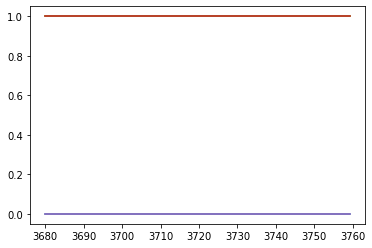

In [216]:
for ii in range(5):
    pl.plot(wave[100:200], unit_weights[ii,100:200])

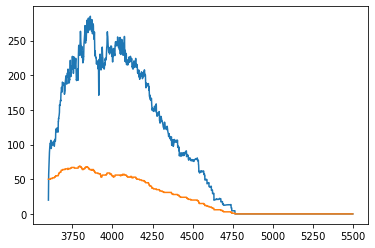

In [217]:
pl.plot(wave, np.sum(weights[100:200,:],axis=0))
unit_weights = np.zeros(weights.shape)
unit_weights[weights>0] = 1
pl.plot(wave, np.sum(unit_weights[100:200,:],axis=0))

# cross-check plots:

In [5]:
# for box 0, plot the mean delta f in each redshift bin:

fin = fits.open("/pscratch/sd/q/qhang/desi-lya/results/run-0/catalogue/delta-raw.fits")
fin[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   56 / length of dimension 1                          
NAXIS2  =              2554104 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    7 / number of table fields                         
TTYPE1  = 'RA      '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'DEC     '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'Z       '        

Text(0, 0.5, 'counts')

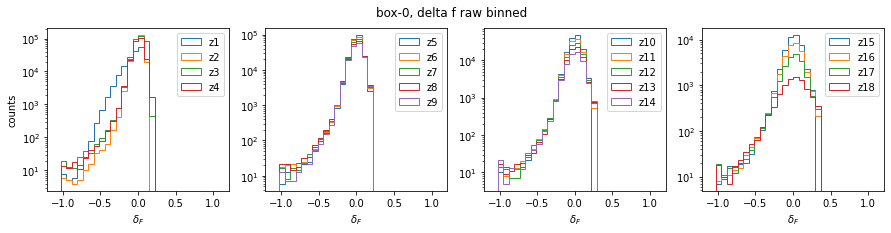

In [20]:
zbins = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/delta_F/zbins.txt")
zbin_edges = zbins[:,0]
#print(len(zbin_edges))

deltaf_raw = fin[1].data['DELTA_F']
totweight_raw = fin[1].data['TOTWEIGHTS']
z = fin[1].data['Z']

fig,axarr=pl.subplots(1,4,figsize=[15,3])

fig.suptitle("box-0, delta f raw binned")


#totflux = np.zeros(len(zbin_edges)-1)
#totweight = np.zeros(len(zbin_edges)-1)

for ii in range(4):
    pl.sca(axarr[ii])
    for jj in range(5):
        kk = ii*5 + jj
        ind = (z>zbin_edges[kk])&(z<=zbin_edges[kk+1])
        if sum(ind)>0:
            cc = pl.hist(deltaf_raw[ind], range=[-1.1,1.1], bins=30, histtype='step', label=f'z{kk}')
            meanflux[kk] = np.mean(deltaf_raw[ind])    
    pl.legend()
    pl.yscale('log')
    pl.xlabel("$\\delta_F$")
pl.sca(axarr[0])
pl.ylabel("counts")

In [26]:
meanflux = np.zeros((len(zbin_edges)-1, 10))
for ii in range(10):
    fin = fits.open(f"/pscratch/sd/q/qhang/desi-lya/results/run-{ii}/catalogue/delta-raw.fits")
    deltaf_raw = fin[1].data['DELTA_F']
    z = fin[1].data['Z']
    for kk in range(len(zbin_edges)-1):
        ind = (z>zbin_edges[kk])&(z<=zbin_edges[kk+1])
        if sum(ind)>0:
            meanflux[kk,ii] = np.mean(deltaf_raw[ind])   

Text(0, 0.5, '$\\langle \\delta_F(z) \\rangle$')

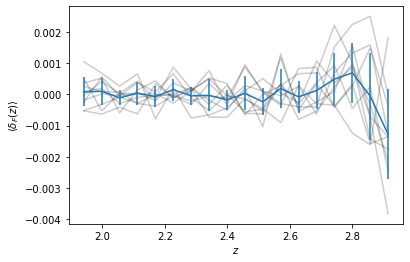

In [28]:
meanmeanflux = np.mean(meanflux,axis=1)
stdmeanflux = np.std(meanflux,axis=1)

for ii in range(10):
    pl.plot(zbins[:-1,1][1:19], meanflux[1:19,ii], 'k-', alpha=0.2)

pl.errorbar(zbins[:-1,1][1:19], meanmeanflux[1:19], yerr=stdmeanflux[1:19])
pl.xlabel("$z$")
pl.ylabel("$\\langle \\delta_F(z) \\rangle$")

## Mean of delta f over full field:

In [30]:
# let's check for the true_cont case:
sim_mode = 1
sim_num = 0
run_mode = 0
nchunks = 32

emit = 1215.67
lambda_rf_min=1040
lambda_rf_max=1200
#dodgy_lowz_cut=3600

if sim_mode == 1:
    sim_mode_tag = "true_cont"
elif sim_mode == 2:
    sim_mode_tag = "uncontaminated"
elif sim_mode == 3:
    sim_mode_tag = "baseline"

# read in redshift bin somewhere, or save it with the results;
simroot = "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/lya_mocks/mock_analysis/qq_desi_y5/skewers_desi_footprint.5/"
simroot += f"analysis-{sim_num}/jura-0/{sim_mode_tag}/deltas_lya/Delta/"

#saveroot = args.outroot + f"run-{sim_num}/catalogue/"

#mask = hp.read_map(args.mask)
#nside=hp.get_nside(mask)
#npix = round(12*nside**2,0)
#usepix = np.arange(npix)[mask==1]

if run_mode == 0 or run_mode == 2:
    
    fname_list = glob(simroot + "*.fits.gz", recursive = True)
    print("Total files to go through: ", len(fname_list))
    print(f"Splitting into {nchunks} chunks...")
    # here, split the file list to chunks and send to different nodes:
    Nfiles = int(len(fname_list)/nchunks)+1
    fname_chunks = []
    for kk in range(nchunks):
        if kk < nchunks - 1 :
            fname_chunks.append(fname_list[(kk*Nfiles):((kk+1)*Nfiles)])
        elif kk == nchunks - 1 :
            fname_chunks.append(fname_list[(kk*Nfiles):])
        print(f"Chunk {kk} contains {len(fname_chunks[kk])} files.")

    # here call mpi
    #if args.run_mode == 0:
    #    comm,rank,my_tasks = mpi.distribute(args.nchunks)
    #    s = stats.Stats(comm)
    #elif args.run_mode == 2:
    #    my_tasks = [0]
    my_tasks = np.arange(nchunks)

    Deltaf_sum = 0
    Npix = 0
    Deltaf_w_sum = 0
    Totweight = 0
    
    # save the different parts separately
    for task in my_tasks:

        print(f"Working on chunk {task}...")

        tot_los = 0
    
        for mm in range(len(fname_chunks[task])):
        
            hdu = fits.open(fname_chunks[task][mm])
            wave = hdu[1].data
            #ra = hdu[2].data['RA']*180/np.pi
            #dec = hdu[2].data['DEC']*180/np.pi
            zqso = hdu[2].data['Z']
            #qid= hdu[2].data['LOS_ID']
            delta = hdu[3].data
            weights = hdu[4].data
            #cont = hdu[5].data
            objred = (wave-emit)/emit
        
            # grab all objects in this file:
            nobj = len(delta)
            #print(f"number of los: {nobj}")
            tot_los += nobj
            #bin_tag = np.digitize(objred, bin_edges)

            # select pixels in forest
            lambda_obs_min=lambda_rf_min*(1+zqso)
            lambda_obs_max=lambda_rf_max*(1+zqso)
            in_forest=np.logical_and(wave[None,:] > lambda_obs_min[:,None], wave[None,:] < lambda_obs_max[:,None])
            #in_forest *= wave[None,:] > dodgy_lowz_cut
            
            # select objects that lie inside the mask
            #pix = hp.ang2pix(nside, np.radians(90 - dec), np.radians(ra))
            #sel1 = np.in1d(pix,usepix)
            
            #useind = (bin_tag == kk+1)[None,:]*in_forest*sel1[:,None]
            useind = in_forest
            num_pix = np.sum(useind,axis=0)
        
            # make a mask for objects without any pixel
            #obj_mask = num_pix>0
            
            # just in case, should get rid of any nan or inf
            delta_0 = np.nan_to_num(delta, 0)
            weights_0 = np.nan_to_num(weights, 0)
        
            # compute delta_F
            sum_deltaf = np.sum((delta_0*useind.astype(int)),axis=0)
            sum_deltaf_w = np.sum(((delta_0*weights_0)*useind.astype(int)),axis=0)
            tot_weights = np.sum((weights_0*useind.astype(int)),axis=0)

            Deltaf_sum += sum_deltaf
            Npix += num_pix
            Deltaf_w_sum += sum_deltaf_w
            Totweight += tot_weights

        print(f"Tot los: {tot_los}")
print(Deltaf_sum.shape)

Total files to go through:  1248
Splitting into 32 chunks...
Chunk 0 contains 40 files.
Chunk 1 contains 40 files.
Chunk 2 contains 40 files.
Chunk 3 contains 40 files.
Chunk 4 contains 40 files.
Chunk 5 contains 40 files.
Chunk 6 contains 40 files.
Chunk 7 contains 40 files.
Chunk 8 contains 40 files.
Chunk 9 contains 40 files.
Chunk 10 contains 40 files.
Chunk 11 contains 40 files.
Chunk 12 contains 40 files.
Chunk 13 contains 40 files.
Chunk 14 contains 40 files.
Chunk 15 contains 40 files.
Chunk 16 contains 40 files.
Chunk 17 contains 40 files.
Chunk 18 contains 40 files.
Chunk 19 contains 40 files.
Chunk 20 contains 40 files.
Chunk 21 contains 40 files.
Chunk 22 contains 40 files.
Chunk 23 contains 40 files.
Chunk 24 contains 40 files.
Chunk 25 contains 40 files.
Chunk 26 contains 40 files.
Chunk 27 contains 40 files.
Chunk 28 contains 40 files.
Chunk 29 contains 40 files.
Chunk 30 contains 40 files.
Chunk 31 contains 8 files.
Working on chunk 0...
Tot los: 28156
Working on chunk 

In [37]:
# print avg:
fin = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/delta_F/zbins.txt")
bin_edges = fin[:,0]
zbin_centre = fin[:-1,1]
nbin = len(bin_edges)-1

bin_tag = np.digitize(objred, bin_edges)

mean_deltaf = np.zeros(nbin)
mean_deltaf_w = np.zeros(nbin)
for kk in range(nbin):
    if (kk + 1) in bin_tag:
        useind = (bin_tag == kk+1)
        mean_deltaf[kk] = np.mean(( Deltaf_sum /  Npix)[useind])
        mean_deltaf_w[kk] = np.mean(( Deltaf_w_sum / Totweight)[useind])

/tmp/ipykernel_177581/3581875730.py:14: RuntimeWarning: invalid value encountered in divide
  mean_deltaf[kk] = np.mean(( Deltaf_sum /  Npix)[useind])
/tmp/ipykernel_177581/3581875730.py:15: RuntimeWarning: invalid value encountered in divide
  mean_deltaf_w[kk] = np.mean(( Deltaf_w_sum / Totweight)[useind])


In [54]:
wavecen = zbin_centre*emit + emit

/tmp/ipykernel_177581/3244246626.py:6: RuntimeWarning: invalid value encountered in divide
  pl.plot(wave, Deltaf_sum /  Npix, label="Direct mean")
/tmp/ipykernel_177581/3244246626.py:7: RuntimeWarning: invalid value encountered in divide
  pl.plot(wave, Deltaf_w_sum / Totweight , label="Weighted mean")


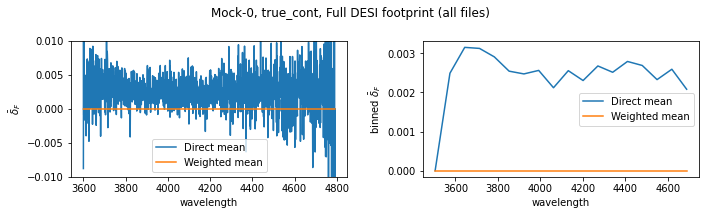

In [58]:
fig,axarr=pl.subplots(1,2,figsize=[10,3])

pl.suptitle("Mock-0, true_cont, Full DESI footprint (all files)")

pl.sca(axarr[0])
pl.plot(wave, Deltaf_sum /  Npix, label="Direct mean")
pl.plot(wave, Deltaf_w_sum / Totweight , label="Weighted mean")
pl.ylim([-0.01,0.01])
pl.xlabel("wavelength")
pl.ylabel("$\\bar{\\delta}_F$")
pl.legend()

pl.sca(axarr[1])
pl.plot(wavecen, mean_deltaf, label="Direct mean")
pl.plot(wavecen, mean_deltaf_w, label="Weighted mean")
pl.xlabel("wavelength")
pl.ylabel("binned $\\bar{\\delta}_F$")
pl.legend()
#pl.title("Full DESI footprint")

pl.tight_layout()

In [38]:
mean_deltaf, mean_deltaf_w

(array([0.        , 0.00248994, 0.00315126, 0.00312443, 0.00290843,
        0.00254281, 0.0024724 , 0.00256197, 0.00211918, 0.00255524,
        0.00230362, 0.00267597, 0.00251437, 0.00279094, 0.00268827,
        0.00232694, 0.0025919 , 0.00208068,        nan,        nan]),
 array([ 0.00000000e+00,  1.67336542e-14, -2.11953516e-15, -2.18740855e-15,
        -1.20128172e-15,  4.20433924e-15, -9.52576424e-15, -1.93399830e-15,
        -6.58265169e-16, -4.80829610e-15, -2.59479672e-15,  3.50308986e-15,
         2.23808484e-16, -5.89886736e-16,  1.23558082e-18,  2.52254492e-16,
        -1.04466676e-15, -4.91962481e-16,             nan,             nan]))

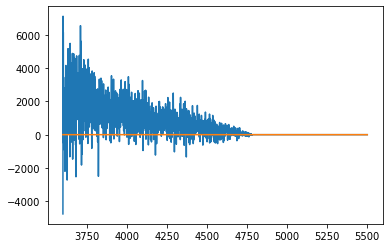

In [34]:
pl.plot(wave, Deltaf_sum)
pl.plot(wave, Deltaf_w_sum)

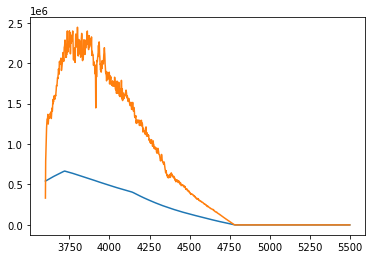

In [33]:
pl.plot(wave, Npix)
pl.plot(wave, Totweight)

In [35]:
Deltaf_w_sum

array([ 1.37322331e-08, -7.90931409e-09,  1.20975443e-08, ...,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

## now also apply the mask

In [40]:
# let's check for the true_cont case:
sim_mode = 1
sim_num = 0
run_mode = 0
nchunks = 32

emit = 1215.67
lambda_rf_min=1040
lambda_rf_max=1200
#dodgy_lowz_cut=3600

if sim_mode == 1:
    sim_mode_tag = "true_cont"
elif sim_mode == 2:
    sim_mode_tag = "uncontaminated"
elif sim_mode == 3:
    sim_mode_tag = "baseline"

# read in redshift bin somewhere, or save it with the results;
simroot = "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/lya_mocks/mock_analysis/qq_desi_y5/skewers_desi_footprint.5/"
simroot += f"analysis-{sim_num}/jura-0/{sim_mode_tag}/deltas_lya/Delta/"

#saveroot = args.outroot + f"run-{sim_num}/catalogue/"

mask = hp.read_map("/pscratch/sd/q/qhang/desi-lya/desixlsst-mask-nside-128.fits")
nside=hp.get_nside(mask)
npix = round(12*nside**2,0)
usepix = np.arange(npix)[mask==1]

if run_mode == 0 or run_mode == 2:
    
    fname_list = glob(simroot + "*.fits.gz", recursive = True)
    print("Total files to go through: ", len(fname_list))
    print(f"Splitting into {nchunks} chunks...")
    # here, split the file list to chunks and send to different nodes:
    Nfiles = int(len(fname_list)/nchunks)+1
    fname_chunks = []
    for kk in range(nchunks):
        if kk < nchunks - 1 :
            fname_chunks.append(fname_list[(kk*Nfiles):((kk+1)*Nfiles)])
        elif kk == nchunks - 1 :
            fname_chunks.append(fname_list[(kk*Nfiles):])
        print(f"Chunk {kk} contains {len(fname_chunks[kk])} files.")

    # here call mpi
    #if args.run_mode == 0:
    #    comm,rank,my_tasks = mpi.distribute(args.nchunks)
    #    s = stats.Stats(comm)
    #elif args.run_mode == 2:
    #    my_tasks = [0]
    my_tasks = np.arange(nchunks)

    Deltaf_sum2 = 0
    Npix2 = 0
    Deltaf_w_sum2 = 0
    Totweight2 = 0
    
    # save the different parts separately
    for task in my_tasks:

        print(f"Working on chunk {task}...")

        tot_los = 0
    
        for mm in range(len(fname_chunks[task])):
        
            hdu = fits.open(fname_chunks[task][mm])
            wave = hdu[1].data
            ra = hdu[2].data['RA']*180/np.pi
            dec = hdu[2].data['DEC']*180/np.pi
            zqso = hdu[2].data['Z']
            #qid= hdu[2].data['LOS_ID']
            delta = hdu[3].data
            weights = hdu[4].data
            #cont = hdu[5].data
            objred = (wave-emit)/emit
        
            # grab all objects in this file:
            nobj = len(delta)
            #print(f"number of los: {nobj}")
            tot_los += nobj
            #bin_tag = np.digitize(objred, bin_edges)

            # select pixels in forest
            lambda_obs_min=lambda_rf_min*(1+zqso)
            lambda_obs_max=lambda_rf_max*(1+zqso)
            in_forest=np.logical_and(wave[None,:] > lambda_obs_min[:,None], wave[None,:] < lambda_obs_max[:,None])
            #in_forest *= wave[None,:] > dodgy_lowz_cut
            
            # select objects that lie inside the mask
            pix = hp.ang2pix(nside, np.radians(90 - dec), np.radians(ra))
            sel1 = np.in1d(pix,usepix)
            
            #useind = (bin_tag == kk+1)[None,:]*in_forest*sel1[:,None]
            useind = in_forest*sel1[:,None]
            num_pix = np.sum(useind,axis=0)
        
            # make a mask for objects without any pixel
            #obj_mask = num_pix>0
            
            # just in case, should get rid of any nan or inf
            delta_0 = np.nan_to_num(delta, 0)
            weights_0 = np.nan_to_num(weights, 0)
        
            # compute delta_F
            sum_deltaf = np.sum((delta_0*useind.astype(int)),axis=0)
            sum_deltaf_w = np.sum(((delta_0*weights_0)*useind.astype(int)),axis=0)
            tot_weights = np.sum((weights_0*useind.astype(int)),axis=0)

            Deltaf_sum2 += sum_deltaf
            Npix2 += num_pix
            Deltaf_w_sum2 += sum_deltaf_w
            Totweight2 += tot_weights

        print(f"Tot los: {tot_los}")
print(Deltaf_sum2.shape)

Total files to go through:  1248
Splitting into 32 chunks...
Chunk 0 contains 40 files.
Chunk 1 contains 40 files.
Chunk 2 contains 40 files.
Chunk 3 contains 40 files.
Chunk 4 contains 40 files.
Chunk 5 contains 40 files.
Chunk 6 contains 40 files.
Chunk 7 contains 40 files.
Chunk 8 contains 40 files.
Chunk 9 contains 40 files.
Chunk 10 contains 40 files.
Chunk 11 contains 40 files.
Chunk 12 contains 40 files.
Chunk 13 contains 40 files.
Chunk 14 contains 40 files.
Chunk 15 contains 40 files.
Chunk 16 contains 40 files.
Chunk 17 contains 40 files.
Chunk 18 contains 40 files.
Chunk 19 contains 40 files.
Chunk 20 contains 40 files.
Chunk 21 contains 40 files.
Chunk 22 contains 40 files.
Chunk 23 contains 40 files.
Chunk 24 contains 40 files.
Chunk 25 contains 40 files.
Chunk 26 contains 40 files.
Chunk 27 contains 40 files.
Chunk 28 contains 40 files.
Chunk 29 contains 40 files.
Chunk 30 contains 40 files.
Chunk 31 contains 8 files.
Working on chunk 0...
Tot los: 28156
Working on chunk 

In [42]:
# print avg:
fin = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/delta_F/zbins.txt")
bin_edges = fin[:,0]
zbin_centre = fin[:-1,1]
nbin = len(bin_edges)-1

bin_tag = np.digitize(objred, bin_edges)

mean_deltaf2 = np.zeros(nbin)
mean_deltaf_w2 = np.zeros(nbin)
for kk in range(nbin):
    if (kk + 1) in bin_tag:
        useind = (bin_tag == kk+1)
        mean_deltaf2[kk] = np.mean(( Deltaf_sum2 /  Npix2)[useind])
        mean_deltaf_w2[kk] = np.mean(( Deltaf_w_sum2 / Totweight2)[useind])

/tmp/ipykernel_177581/2154192044.py:14: RuntimeWarning: invalid value encountered in divide
  mean_deltaf2[kk] = np.mean(( Deltaf_sum2 /  Npix2)[useind])
/tmp/ipykernel_177581/2154192044.py:15: RuntimeWarning: invalid value encountered in divide
  mean_deltaf_w2[kk] = np.mean(( Deltaf_w_sum2 / Totweight2)[useind])


/tmp/ipykernel_177581/2347438886.py:6: RuntimeWarning: invalid value encountered in divide
  pl.plot(wave, Deltaf_sum2 /  Npix2, label="Direct mean")
/tmp/ipykernel_177581/2347438886.py:7: RuntimeWarning: invalid value encountered in divide
  pl.plot(wave, Deltaf_w_sum2 / Totweight2 , label="Weighted mean")


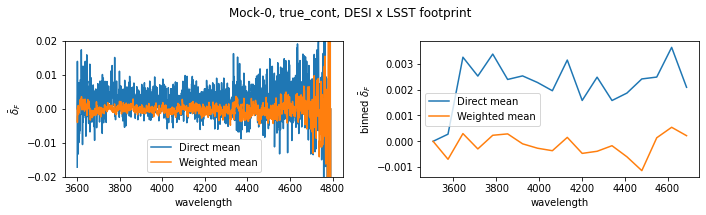

In [60]:
fig,axarr=pl.subplots(1,2,figsize=[10,3])

pl.suptitle("Mock-0, true_cont, DESI x LSST footprint")

pl.sca(axarr[0])
pl.plot(wave, Deltaf_sum2 /  Npix2, label="Direct mean")
pl.plot(wave, Deltaf_w_sum2 / Totweight2 , label="Weighted mean")
pl.ylim([-0.02,0.02])
pl.xlabel("wavelength")
pl.ylabel("$\\bar{\\delta}_F$")
pl.legend()

pl.sca(axarr[1])
pl.plot(wavecen, mean_deltaf2, label="Direct mean")
pl.plot(wavecen, mean_deltaf_w2, label="Weighted mean")
pl.xlabel("wavelength")
pl.ylabel("binned $\\bar{\\delta}_F$")
pl.legend()
#pl.title("Full DESI footprint")

pl.tight_layout()

In [44]:
mean_deltaf2, mean_deltaf_w2

(array([0.        , 0.00027568, 0.00325699, 0.0025261 , 0.003378  ,
        0.00239459, 0.00253273, 0.00227795, 0.001958  , 0.00314612,
        0.00158143, 0.00248325, 0.00157949, 0.00186731, 0.00241492,
        0.00248745, 0.00363798, 0.00209124,        nan,        nan]),
 array([ 0.00000000e+00, -6.96802693e-04,  2.98225542e-04, -2.95542097e-04,
         2.32864586e-04,  2.86658071e-04, -9.77310970e-05, -2.68061938e-04,
        -3.64852219e-04,  1.51400214e-04, -4.68642520e-04, -3.87137861e-04,
        -1.71340374e-04, -6.00464306e-04, -1.13680913e-03,  1.35932347e-04,
         5.42004532e-04,  2.17276840e-04,             nan,             nan]))

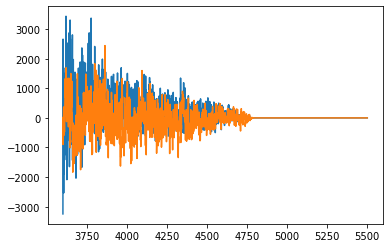

In [45]:
pl.plot(wave, Deltaf_sum2)
pl.plot(wave, Deltaf_w_sum2)